In [20]:
# Library import

import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

import pandas as pd
from pathlib import Path
import datetime as dt
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

from google.cloud import bigquery
from google.oauth2 import service_account

delta=dt.timedelta(days=1)

In [ ]:
# Información del proyecto y autenticación a BQ
project_id = "enersinc-tbsg-bq"
key_path = "C:\BigQuery\eramirez-tbsg.json"

# Cargar las credenciales del archivo JSON
credentials = service_account.Credentials.from_service_account_file(key_path)

# Crear el cliente de BigQuery
client = bigquery.Client(project=project_id, credentials=credentials)

In [22]:
# Get main path and other folders
s_mainpath=Path.cwd()
print(s_mainpath)
s_parentpath=s_mainpath.parent.parent.parent
print(s_parentpath)
# folderpath=s_parentpath.joinpath(r'DatosXM\Despacho\\')

# Ruta General
sRutaDesp=r'C:\Información XM\\Publico\\'

sRutaPrint=s_mainpath.joinpath('Print')

c:\Alejo\Eje de Planeación\Análisis Eléctrico\ScriptsPython
c:\Alejo


In [23]:
# Rango de análisis

s_FechaIni='2025-01-01'
s_FechaFin='2025-02-17'

#Camniar a formato fecha
d_FechaIni=dt.datetime.strptime(s_FechaIni,'%Y-%m-%d')
d_FechaFin=dt.datetime.strptime(s_FechaFin,'%Y-%m-%d')

In [24]:
# Inicializar fecha
d_Fecha=d_FechaIni

# Encabezados 

l_colGen=['Nombre'] # Archivo de dDem

for i in range(1,25): 
    l_colGen.append(i)

filetypes=['dDEC'] # Lista con los archivos a analizar


df_Gen=pd.DataFrame()
df_GenN=pd.DataFrame()


while d_Fecha<=d_FechaFin:

    ano=d_Fecha.year
    mes=d_Fecha.month
    dia=d_Fecha.day

    for filetype in filetypes:

        if filetype=='dDEC':
            folderpath=Path(sRutaDesp + 'Despacho\\')
            file=filetype + "{:02d}".format(mes) + "{:02d}".format(dia) + '.txt'
            s_filepath=folderpath.joinpath(str(ano) + '-' + "{:02d}".format(mes),file)
            df_Aux = pd.read_csv(s_filepath, sep=',',names=l_colGen,encoding="ISO-8859-1")
            df_Aux['Fecha']=d_Fecha
            # df_Aux2=df_Aux[df_Aux['Nombre'].isin(['TEBSA','TCANDELCC','BARRANQ3','BARRANQ4'])]
            # df_Aux2=df_Aux[df_Aux['Nombre'].isin(['TEBSA','FLORES IV','FLORES1'])]
            df_Aux = df_Aux[df_Aux['Nombre'] != 'Total']
            df_Gen=pd.concat([df_Gen,df_Aux])


            folderpath=Path(sRutaDesp + 'Despacho\Ties\Despachos\\')
            file=filetype + "{:02d}".format(mes) + "{:02d}".format(dia) + '_NAL.txt'
            s_filepath=folderpath.joinpath(str(ano) + '-' + "{:02d}".format(mes),file)
            df_Aux = pd.read_csv(s_filepath, sep=',',names=l_colGen,encoding="ISO-8859-1")
            df_Aux['Fecha']=d_Fecha
            # df_Aux2=df_Aux[df_Aux['Nombre'].isin(['TEBSA','TCANDELCC','BARRANQ3','BARRANQ4'])]
            # df_Aux2=df_Aux[df_Aux['Nombre'].isin(['TEBSA','FLORES IV','FLORES1'])]
            df_Aux = df_Aux[df_Aux['Nombre'] != 'Total']
            df_GenN=pd.concat([df_GenN,df_Aux])

    d_Fecha=d_Fecha+delta

In [25]:
# List of columns to subtract
columns_to_subtract = [i for i in range(1,25)]
# Merge DataFrames on Key1 and Key2
merged_df = pd.merge(df_Gen, df_GenN, on=['Nombre', 'Fecha'], how='inner', suffixes=('_df1', '_df2'))

# Perform subtraction for each column
l_dif=['Fecha','Nombre']
for col in columns_to_subtract:
    l_dif.append(f'{col}_Difference')
    merged_df[f'{col}_Difference'] = merged_df[f'{col}_df1'] - merged_df[f'{col}_df2']

merged_df=merged_df[l_dif]
merged_df=pd.melt(merged_df, id_vars=['Fecha','Nombre'], var_name='Periodo', value_name='Dif')
df_group=merged_df.groupby(['Fecha','Nombre'])[['Dif']].sum()
df_group=df_group.reset_index()
df_group['Dif']=df_group['Dif']/1000
df_group = df_group[df_group['Dif'] > 0.20]
df_group = df_group[~df_group['Nombre'].isin(['ELQUIMBO','GUATRON','BETANIA'])]

In [26]:
Df_TPL_Coor=df_Gen.copy()
Df_TPL_Coor=Df_TPL_Coor[(Df_TPL_Coor['Nombre'].isin(['TEBSA','TCANDELCC']))]
Df_TPL_Coor=pd.melt(Df_TPL_Coor, id_vars=['Fecha','Nombre'], var_name='Periodo', value_name='MW')
Df_TPL_Coor=Df_TPL_Coor.groupby(['Fecha','Nombre'])[['MW']].sum().reset_index()
Df_TPL_Coor['MW']=Df_TPL_Coor['MW']/1000


df_TPL_Int=df_group[(df_group['Nombre'].isin(['TEBSA','TCANDELCC']))]

Df_TPL_Coor=Df_TPL_Coor.merge(df_TPL_Int,left_on=['Fecha','Nombre'],right_on=['Fecha','Nombre'], how='left')[['Fecha','Nombre','MW','Dif']]
Df_TPL_Coor

,Fecha,Nombre,MW,Dif
0,2025-01-01,TCANDELCC,2.201,NaN
1,2025-01-01,TEBSA,0.000,NaN
2,2025-01-02,TCANDELCC,4.638,0.453
3,2025-01-02,TEBSA,0.000,NaN
4,2025-01-03,TCANDELCC,5.694,NaN
...,...,...,...,...
91,2025-02-15,TEBSA,0.000,NaN
92,2025-02-16,TCANDELCC,2.553,NaN
93,2025-02-16,TEBSA,0.000,NaN
94,2025-02-17,TCANDELCC,3.642,NaN


In [27]:
# Consulta a la maestra de recursos
query = """
select distinct *
from tbsg.public_maestra_recurso 
where recurso_despacho is not null
"""

# Ejecutar la consulta
df_Comb = client.query(query).to_dataframe()
df_Comb=df_Comb[['recurso_despacho','recurso_ofei','combustible']]
df_Comb=df_Comb.drop_duplicates()

# Consulta a los precios
query = """
select fechaoperacion,planta, hora1 
from tbsg.public_ofei 
where fechaoperacion>='2024-11-01' and fechaoperacion<='2024-11-01' 
	and tipo like 'P%' and tipo not like 'PA%' and tipo!='PRU'
order by fechaoperacion, planta
"""

# Ejecutar la consulta
df_Pre = client.query(query).to_dataframe()
df_Pre['planta']=df_Pre['planta'].str.strip()
df_Pre=df_Pre[['planta','hora1']]
df_Pre=df_Pre.rename(columns={'hora1':'Precio'})
df_Pre['Precio']=df_Pre['Precio'].astype(int)
df_Pre =df_Pre.groupby(['planta'])['Precio'].min()
df_Pre=df_Pre.reset_index()

In [28]:
categories = pd.to_datetime(df_group['Fecha'].drop_duplicates().reset_index(drop=True))
segments = df_group['Nombre'].drop_duplicates().reset_index(drop=True)

from itertools import product
# Create a DataFrame using the Cartesian product of dates and data
df_data= pd.DataFrame(product(categories, segments), columns=['Fecha', 'Nombre'])
df_data.loc[df_data['Nombre'] == 'PROELECT', 'Nombre'] = 'PROELEC1'
df_data=df_data.merge(df_group,left_on=['Fecha','Nombre'],right_on=['Fecha','Nombre'], how='left')
df_data=df_data.fillna(0)
df_data=df_data.merge(df_Comb,left_on=['Nombre'],right_on=['recurso_despacho'], how='left')[['Fecha', 'Nombre','recurso_ofei','Dif','combustible']]
df_data.loc[df_data['combustible'].isna(), 'combustible'] = 'GAS'


df_data=df_data.merge(df_Pre,left_on=['recurso_ofei'],right_on=['planta'], how='left')[['Fecha', 'Nombre','recurso_ofei','planta','Dif','combustible','Precio']]
df_data.loc[df_data['combustible']=='CARBON', 'Precio'] = 0
df_data.loc[df_data['combustible']=='CARBON', 'Nombre'] = 'CARBON'

# Agrupar por planta y las de carbón
df_data=df_data.groupby(['Fecha','Nombre','combustible','Precio'])[['Dif']].sum()
df_data=df_data.reset_index()

# Ordenar datos por Fecha y Precio
df_data = df_data.sort_values(by=['Fecha', 'Precio'], ascending=[True, True])

df_data
# df_data['combustible'].drop_duplicates()
# df_data[df_data['combustible'].isna()]

,Fecha,Nombre,combustible,Precio,Dif
0,2025-01-01,CARBON,CARBON,0.0,5.008
11,2025-01-01,TYOPAL4,GAS,93000.0,0.000
5,2025-01-01,TCANDELCC,GAS,595356.0,0.000
2,2025-01-01,FLORES1,GAS,628616.0,0.000
4,2025-01-01,PROELEC1,GAS,701587.0,0.000
...,...,...,...,...,...
525,2025-02-17,TESORITO,GAS,889257.0,0.000
522,2025-02-17,TEBSA,GAS,902608.0,0.000
526,2025-02-17,TVALLE,ACPM,924555.0,0.000
524,2025-02-17,TERMONORTE,GAS,935000.0,0.000


In [29]:
# df_data=df_data[(df_data.Fecha>pd.to_datetime('2024-12-15'))]

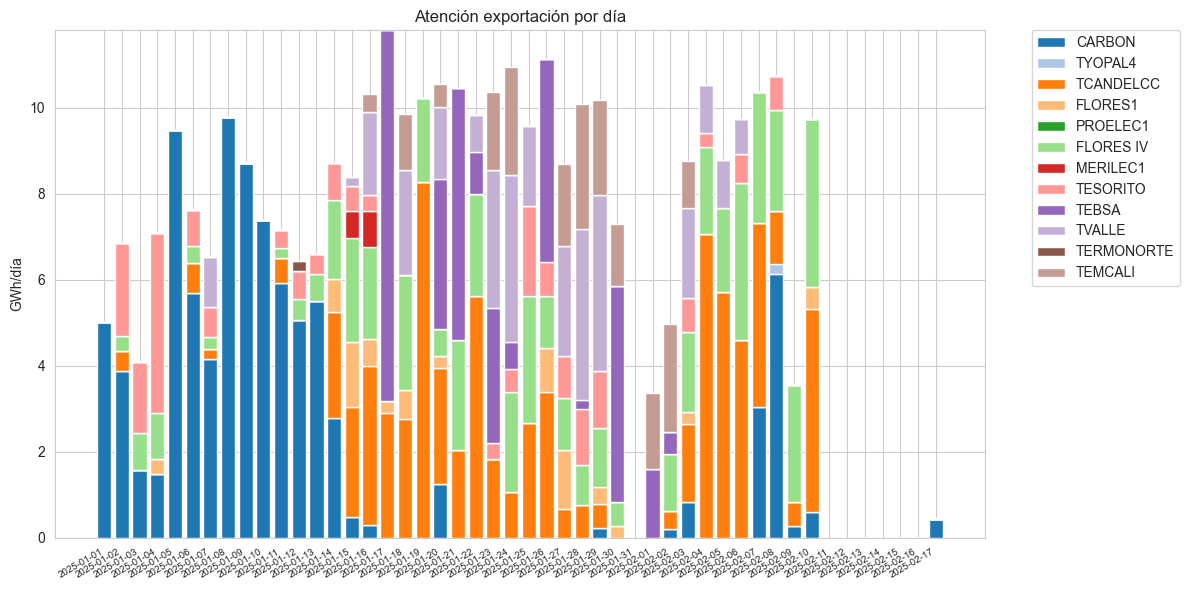

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Estilo de gráfico
sns.set_style("whitegrid")

# Crear categorías y segmentos
categories = pd.to_datetime(df_data['Fecha'].drop_duplicates().reset_index(drop=True))
segments = df_data['Nombre'].drop_duplicates().reset_index(drop=True)

# Crear figura y ejes
fig, ax = plt.subplots(figsize=(12, 6))

# Colores variados
colors = sns.color_palette("tab20", len(segments))  # Paleta de colores con suficientes tonos

# Valores acumulados para apilado
bottom_values = np.zeros(len(categories))

# Crear el gráfico de barras apiladas
for segment, color in zip(segments, colors):
    values = df_data[df_data.Nombre == segment]['Dif'].reset_index(drop=True)
    ax.bar(categories, values, label=segment, bottom=bottom_values, color=color)
    bottom_values += values

# Etiquetas y leyenda
ax.set_ylabel("GWh/día")
ax.set_title("Atención exportación por día")
ax.legend(title="Segments")

# Ajustar ticks y leyenda
plt.xticks(pd.date_range(categories.min(), categories.max(), freq='1D'), rotation=90)
plt.tick_params(axis='x', labelsize=7)
plt.gcf().autofmt_xdate()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

plt.show()


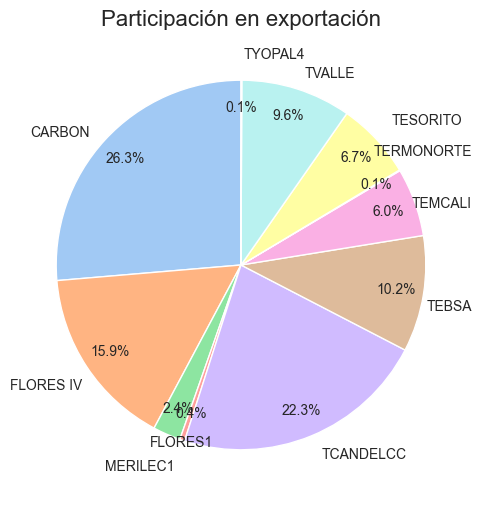

In [31]:
from adjustText import adjust_text
# Agrupar por planta y las de carbón
df_dataPlt=df_data[(df_data.Dif>0)]
df_dataPlt=df_dataPlt.groupby(['Nombre'])[['Dif']].sum()
df_dataPlt=df_dataPlt.reset_index()
df_dataPlt


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Colores usando una paleta de Seaborn
colors = sns.color_palette("pastel", len(df_dataPlt))

# Crear gráfico de pastel
plt.figure(figsize=(8, 6))
wedges, texts, autotexts=plt.pie(
    df_dataPlt["Dif"], 
    labels=df_dataPlt["Nombre"], 
    autopct="%1.1f%%", 
    startangle=90, 
    colors=colors,
    wedgeprops={"edgecolor": "white"},  # Bordes blancos para separar las secciones
    pctdistance=0.85, 
    labeldistance=1.1
)

adjust_text(texts, only_move={'points':'y', 'texts':'y'})
# Título
plt.title("Participación en exportación", fontsize=16)

# Mostrar gráfico
plt.show()

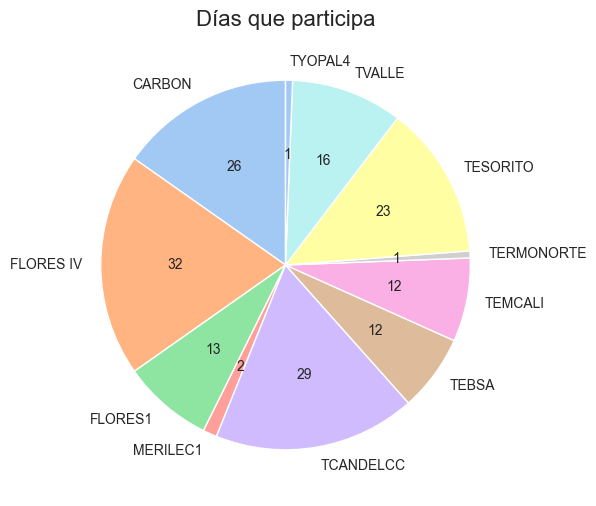

In [32]:
# Agrupar por planta y las de carbón
df_dataPltC=df_data[(df_data.Dif>0)]
df_dataPltC=df_dataPltC.groupby(['Nombre'])[['Dif']].count()
df_dataPltC=df_dataPltC.reset_index()
df_dataPltC

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Colores usando una paleta de Seaborn
colors = sns.color_palette("pastel", len(df_dataPltC))

# Función para mostrar valores absolutos
def absolute_value(val):
    # Calcula el índice del valor correspondiente
    index = int(val / 100 * sum(df_dataPltC["Dif"]))
    return f"{index+1}"

# Crear gráfico de pastel
plt.figure(figsize=(8, 6))
plt.pie(
    df_dataPltC["Dif"], 
    labels=df_dataPltC["Nombre"], 
    autopct=absolute_value,  # Muestra valores absolutos
    startangle=90, 
    colors=colors,
    wedgeprops={"edgecolor": "white"}  # Bordes blancos para separar las secciones
)

# Título
plt.title("Días que participa", fontsize=16)

# Mostrar gráfico
plt.show()

In [33]:
df_dataPltC

,Nombre,Dif
0,CARBON,25
1,FLORES IV,32
2,FLORES1,13
3,MERILEC1,2
4,TCANDELCC,29
5,TEBSA,11
6,TEMCALI,12
7,TERMONORTE,1
8,TESORITO,22
9,TVALLE,16
